In [2]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot  as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings
import matplotlib
import matplotlib.dates as mdates

df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True).drop(columns = 'Unnamed: 0')
df.head()

,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [3]:
#questions:
#include new deaths?
#are all models trained on individual state datasets?
#are each individual state datasets, stationary?, seasonal?

In [4]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

In [5]:
print (df.columns.tolist())

['STATE', 'PROVINCE_STATE_NAME', 'Completeness_pct', 'Administered_Dose1_Recip', 'Administered_Dose1_Recip_5Plus', 'Administered_Dose1_Recip_12Plus', 'Administered_Dose1_Recip_18Plus', 'Administered_Dose1_Recip_65Plus', 'Series_Complete_Yes', 'Series_Complete_5Plus', 'Series_Complete_5to17', 'Series_Complete_12Plus', 'Series_Complete_18Plus', 'Series_Complete_65Plus', 'Booster_Doses', 'Booster_Doses_5Plus', 'Booster_Doses_12Plus', 'Booster_Doses_18Plus', 'Booster_Doses_50Plus', 'Booster_Doses_65Plus', 'Second_Booster_50Plus', 'Second_Booster_65Plus', 'Bivalent_Booster_5Plus', 'Bivalent_Booster_12Plus', 'Bivalent_Booster_18Plus', 'Bivalent_Booster_65Plus', 'PEOPLE_DEATH_NEW_COUNT', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'TOT_POP', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'NAC_MALE', 'N

In [6]:
#separate univariate dataframe for california
ca_uni_df = ca_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT']]
ca_uni_df.head()

,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,
2020-03-01,5
2020-03-02,5
2020-03-03,7
2020-03-04,10
2020-03-05,12


In [7]:
#display the largest 10 values
largest_ten = ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].nlargest(10)
print(largest_ten)

Date
2022-01-10    227972
2022-01-17    221235
2022-01-24    215830
2022-01-20    162854
2022-01-13    159736
2022-01-04    141752
2022-01-11    136412
2022-01-21    134562
2022-01-31    124284
2022-01-27    117445
Name: PEOPLE_POSITIVE_NEW_CASES_COUNT, dtype: int64


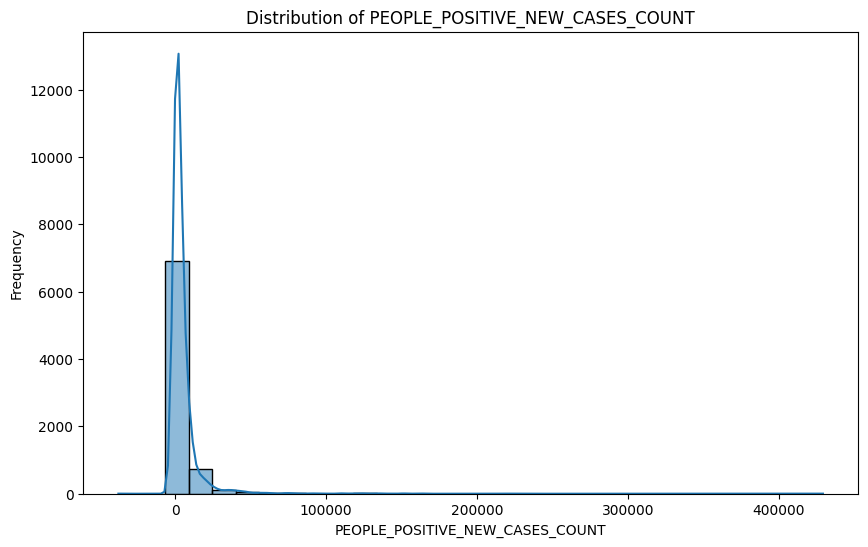

In [8]:
#visualize target distribution
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], kde=True, bins=30)
plt.title('Distribution of PEOPLE_POSITIVE_NEW_CASES_COUNT')
plt.xlabel('PEOPLE_POSITIVE_NEW_CASES_COUNT')
plt.ylabel('Frequency')
plt.show()

In [9]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

In [10]:
ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
Date,,
2020-03-01,NaN,5.0
2020-03-02,NaN,5.0
2020-03-03,NaN,7.0
2020-03-04,NaN,10.0
2020-03-05,NaN,12.0
...,...,...
2022-04-25,4531.0,NaN
2022-04-26,16180.0,NaN
2022-04-27,1852.0,NaN


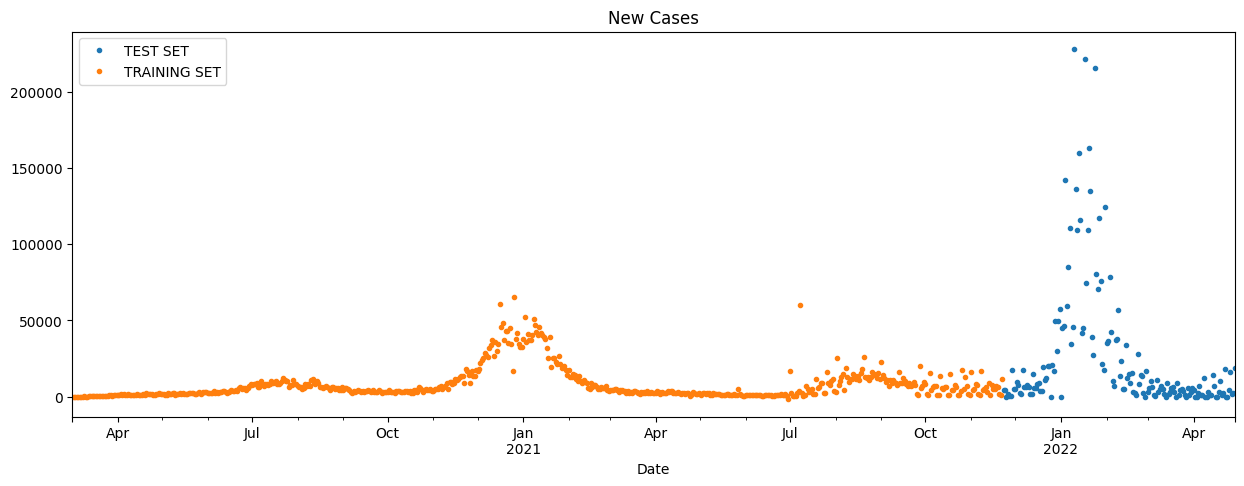

In [11]:
#visualize the 80/20 train/test split
_ = ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='New Cases', style='.')

<Axes: xlabel='Date'>

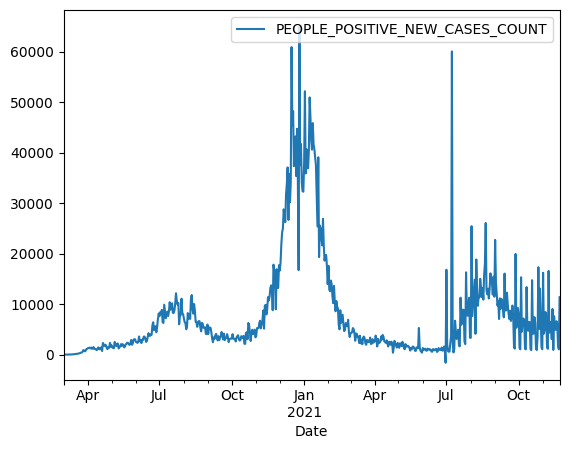

In [12]:
#visualize training dataset
ca_uni_train.plot()

In [13]:
#univariate ARIMA model -- california

#dataset needs to be stationary (mean, var, etc. constant over time)

#stationarity tests -- augmented dickey fuller
from statsmodels.tsa.stattools import adfuller
 
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(col):
    result=adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])


ADF Test Statistic : -4.343798863620733
p-value : 0.0003727147926551251
#Lags Used : 19
Number of Observations Used : 770
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
#identification -- determine values of p & q
#use gridsearch to select values of p and q -- AIC performance metric
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

results=[]
for p in range(1,10):
    for q in range(1,10):
        model=ARIMA(ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
80,9,9,16710.369255
62,7,9,16710.791944
71,8,9,16712.237918
79,9,8,16735.522971
53,6,9,16738.478797
...,...,...,...
2,1,3,17241.703428
56,7,3,17250.630101
28,4,2,17275.503340
1,1,2,17298.972874


In [15]:
#use gridsearch to select values of p and q -- BIC performance metric

results=[]
for p in range(1,10):
    for q in range(1,10):
        model=ARIMA(ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        results.append([p,q,model.bic])
pd.DataFrame(results, columns=['p','q','bic']).sort_values('bic')

,p,q,bic
62,7,9,16790.194972
71,8,9,16796.311712
65,8,3,16798.718928
80,9,9,16799.113816
72,9,1,16800.719804
...,...,...,...
3,1,4,17266.613095
56,7,3,17302.008531
28,4,2,17308.198704
1,1,2,17317.655939


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#optimal ARIMA model revealed via gridsearch with AIC for performance evaluation
#train model
opt_arima=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(9,1,9))
opt_arima_fit_1=opt_arima.fit()

#make predictions
predictions_1 = opt_arima_fit_1.forecast(steps=len(ca_uni_test))

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test, predictions_1)
mse = mean_squared_error(ca_uni_test, predictions_1)
rmse = np.sqrt(mse)
#calculate mape adding a small number to avoid division by zero
predictions_array = np.array(predictions_1)
ca_uni_test_array = np.array(ca_uni_test)
absolute_percent_error = np.where(ca_uni_test_array != 0, np.abs((ca_uni_test_array - predictions_array) / ca_uni_test_array), np.nan)
valid_ape = absolute_percent_error[~np.isnan(absolute_percent_error)]
mape = np.mean(valid_ape) * 100

#naive forecast for mase calculation
naive_forecast = ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

Mean Absolute Error: 23735.634084854126
Root Mean Squared Error: 48917.92524304983
Mean Absolute Percent Error: 4544.501509224237
Mean Absolute Scaled Error: 9.90117792451541


In [18]:
#optimal ARIMA model revealed via gridsearch with BIC for performance evaluation
#train model
opt_arima=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(7,1,9))
opt_arima_fit_2=opt_arima.fit()

#make predictions
predictions_2 = opt_arima_fit_2.forecast(steps=len(ca_uni_test))

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test, predictions_2)
mse = mean_squared_error(ca_uni_test, predictions_2)
rmse = np.sqrt(mse)
#calculate mape adding a small number to avoid division by zero
predictions_array = np.array(predictions_2)
ca_uni_test_array = np.array(ca_uni_test)
absolute_percent_error = np.where(ca_uni_test_array != 0, np.abs((ca_uni_test_array - predictions_array) / ca_uni_test_array), np.nan)
valid_ape = absolute_percent_error[~np.isnan(absolute_percent_error)]
mape = np.mean(valid_ape) * 100

#naive forecast for mase calculation
naive_forecast = ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

Mean Absolute Error: 23722.719844519746
Root Mean Squared Error: 48881.48796583714
Mean Absolute Percent Error: 4619.06984386952
Mean Absolute Scaled Error: 9.895790826329893


In [20]:
#NEED TO IMPROVE PERFORMANCE 

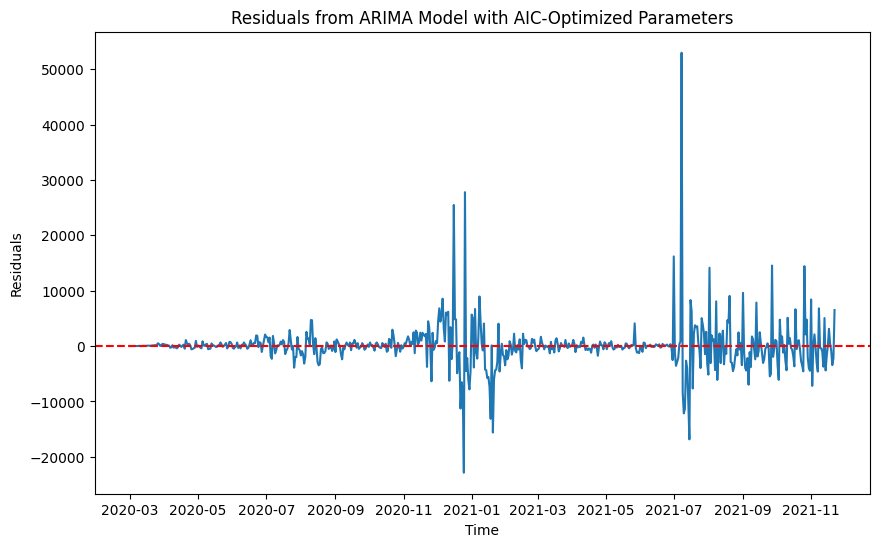

In [25]:
#analyze residuals from the model with parameters optimized using AIC
#extract the residuals
residuals = opt_arima_fit_1.resid

#plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model with AIC-Optimized Parameters')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

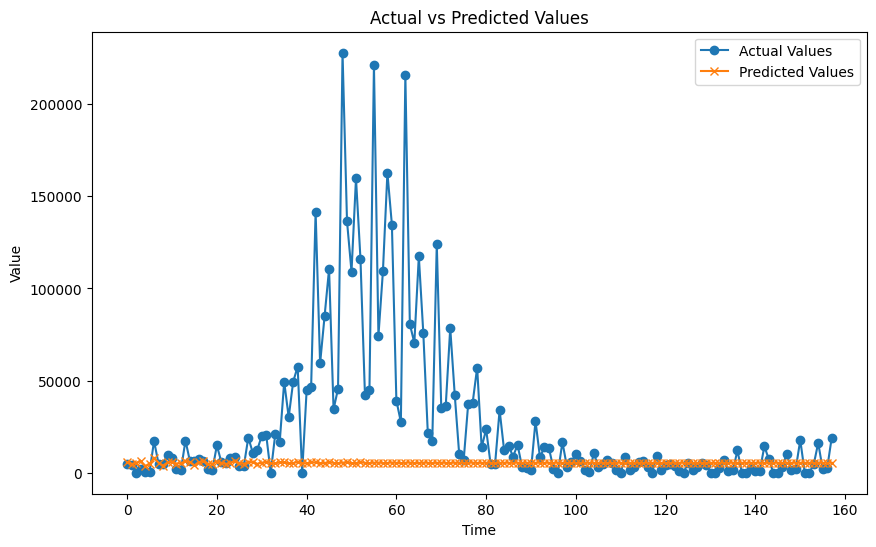

In [26]:
#visualize actual vs predicted values for model with parameters optimized using AIC
ca_uni_test_array = np.array(ca_uni_test)
predictions_array = np.array(predictions_1)

plt.figure(figsize=(10, 6))
plt.plot(ca_uni_test_array, label='Actual Values', marker='o')
plt.plot(predictions_array, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

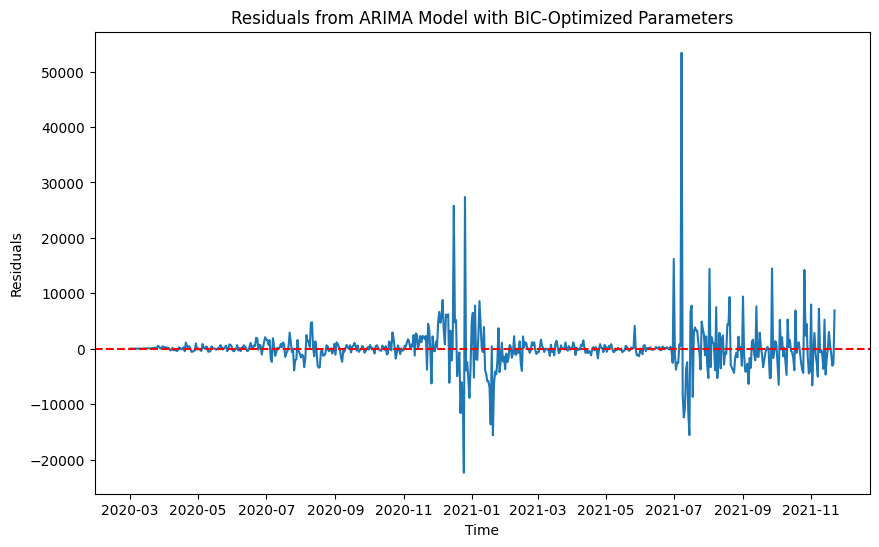

In [27]:
#analyze residuals from the model with parameters optimized using BIC
#extract the residuals
residuals = opt_arima_fit_2.resid

#plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model with BIC-Optimized Parameters')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

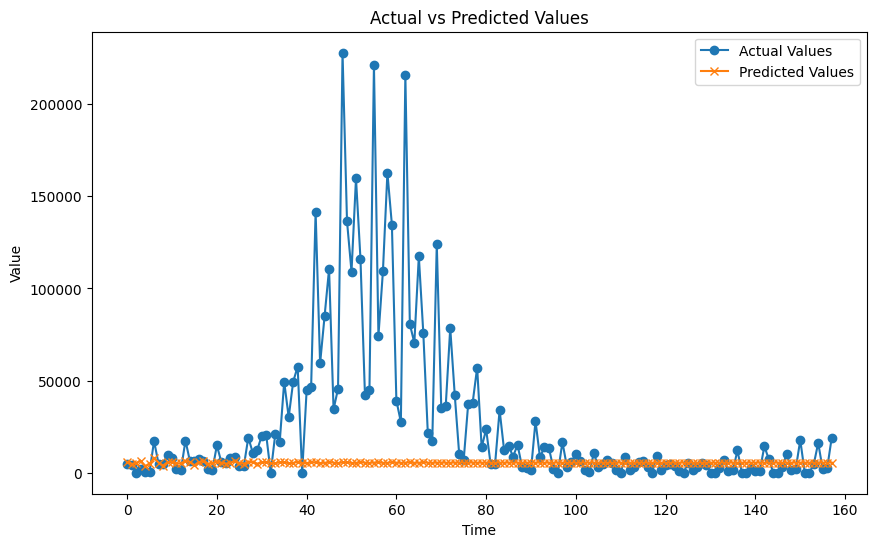

In [28]:
#visualize actual vs predicted values for model with parameters optimized using BIC
ca_uni_test_array = np.array(ca_uni_test)
predictions_array = np.array(predictions_2)

plt.figure(figsize=(10, 6))
plt.plot(ca_uni_test_array, label='Actual Values', marker='o')
plt.plot(predictions_array, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
print("Predicted Values:")
print(predictions_1)

Predicted Values:
2021-11-23    5714.736461
2021-11-24    4712.139626
2021-11-25    5398.804957
2021-11-26    6250.750130
2021-11-27    3664.059268
                 ...     
2022-04-25    5380.348236
2022-04-26    5383.783338
2022-04-27    5384.391090
2022-04-28    5381.004400
2022-04-29    5381.777867
Freq: D, Name: predicted_mean, Length: 158, dtype: float64


In [24]:
print("Predicted Values:")
print(predictions_2)

Predicted Values:
2021-11-23    5913.343396
2021-11-24    4752.269678
2021-11-25    5259.447098
2021-11-26    6469.112810
2021-11-27    3597.924540
                 ...     
2022-04-25    5476.754764
2022-04-26    5478.413705
2022-04-27    5479.058794
2022-04-28    5477.300509
2022-04-29    5477.398275
Freq: D, Name: predicted_mean, Length: 158, dtype: float64


It looks like we have a bias problem.

In [ ]:
#diagnose underfitting/overfitting issues

#fixing high bias -- decrease regularization parameter